# 20220327-zoo
- Cumulative statistics (longest simpoint of each trace)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
- Phase behavior (per-trace, across simpoints)
    - IPC
    - MPKI
    
- Collecting statistics:
    - Create Condor sweep using `Pythia/sim_caches.py condor_setup`
    - Evaluate Condor sweep using `Pythia/sim_caches.py eval`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

In [2]:
data_path = '/u/cmolder/GitHub/Pythia/out/stats.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetching_zoo/champsim/weights.txt'

df = pd.read_csv(data_path)
df

,full_trace,trace,simpoint,prefetcher,accuracy,coverage,mpki,mpki_reduction,ipc,ipc_improvement,baseline_prefetcher,path,baseline_path
0,astar_313B,astar,313B,bingo,6.621630,9.790954,34.204599,41.612062,0.10707,-5.814567,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
1,astar_313B,astar,313B,bop_scooby,38.924502,10.385252,33.979259,41.996722,0.11269,-0.870866,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
2,astar_313B,astar,313B,sisb_bingo,10.021108,27.974336,27.309999,53.381282,0.12082,6.280788,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
3,astar_313B,astar,313B,spp_dev2_bingo,6.843329,10.352918,33.991519,41.975794,0.10756,-5.383533,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
4,astar_313B,astar,313B,sms_bingo,7.084784,13.300036,32.874059,43.883320,0.10813,-4.882125,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,cc,cc,NaN,sisb_scooby,99.036219,95.905844,0.252860,95.905884,0.56211,45.968475,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
563,cc,cc,NaN,scooby,98.834881,94.142601,0.361760,94.142658,0.55491,44.098782,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
564,cc,cc,NaN,bingo_scooby,99.901567,98.200165,0.111160,98.200182,0.56815,47.536939,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...
565,cc,cc,NaN,sms_bingo,99.891356,98.005544,0.123180,98.005563,0.56745,47.355164,no,/scratch/cluster/cmolder/prefetching_zoo/2022_...,/scratch/cluster/cmolder/prefetching_zoo/2022_...


In [3]:
weights = pd.read_csv(weight_path, sep=' ', header=None)
weights.columns = ['trace', 'weight']
weights

,trace,weight
0,astar_163B,0.452174
1,astar_23B,0.162319
2,astar_313B,0.220290
3,bwaves_1609B,0.262524
4,bwaves_1861B,0.337187
...,...,...
63,zeusmp_600B,0.340000
64,cc,1.000000
65,pr,1.000000
66,bfs,1.000000


# Helper functions

In [35]:
def get_longest_simpoints(weights):
    weights_ = weights.copy()
    trace_tokens = weights.trace.str.split(pat='_', expand=True)

    weights_['trace_name'] = trace_tokens[0]
    weights_['simpoint'] = trace_tokens[1]
    
    idx = (weights_.groupby('trace_name')['weight'].transform(max) == weights_['weight'])
    traces = weights[idx].trace
    #traces = traces.append(pd.Series(['amean'])) # Avoid removing statistics
    #traces = traces.append(pd.Series(['gmean']))
    return traces

def get_best_prefetchers(df, filter_by, filter_count):
    mean_metric = 'amean' if filter_by in ['accuracy', 'coverage'] else 'gmean'
    
    pf_avgs = []
    for i, (pf, df_pf) in enumerate(df.groupby('prefetcher')):
        avg = mean(df_pf[filter_by], by=mean_metric)
        pf_avgs.append((avg, pf))
        
    best = sorted(pf_avgs)[::-1][:filter_count]
    return [pf for _, pf in best]
        

def mean(values, by='amean'):
    if by == 'amean':
        return np.mean(values)
    else:
        return stats.gmean(values + 100) - 100 # Add 100 to prevent negative values (so that 100 = no prefetcher baseline)

In [6]:
#get_longest_simpoints(weights)

# Cumulative statistics
- Compare prefetchers on the longest simpoint of each trace

In [67]:
def plot_cumulative_statistics(df, weights, metric='accuracy', 
                               filter_by='ipc_improvement', filter_count=10):
    longest_simpoints = get_longest_simpoints(weights)
    #df = df[pd.notna(df[metric])]
    df = df[df.full_trace.isin(longest_simpoints)]
    
    if filter_by is not None:
        best_prefetchers = get_best_prefetchers(df, filter_by, filter_count)
        df = df[df.prefetcher.isin(best_prefetchers)]
    
    
    
    
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('prefetcher'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in ['accuracy', 'coverage'] else 'gmean'
    sep = 3
    
    fig, ax = plt.subplots(dpi=192)
        
    pf_list = best_prefetchers if filter_by is not None else df.prefetcher.unique()
    for i, pf in enumerate(pf_list):
        df_pf = df[df.prefetcher == pf]
        y = df_pf[metric].to_numpy()
        y = np.append(y, mean(y, by=mean_metric))
        #print(pf, y, mean(y, by=mean_metric))
        #display(df_pf)
        
        
        X = np.arange(0, len(y)) * (num_prefetchers + sep) + i
        
        if filter_by is not None:
            label = f'({best_prefetchers.index(pf)+1}) {pf}'
        else:
            label = pf
        
        ax.bar(X, y, label=label)
        
    
    ax.set_xticks(np.arange(0, len(traces) + 1) * (num_prefetchers + sep) + (num_prefetchers)/2)
    ax.set_xticklabels(traces.tolist() + [mean_metric], rotation=45)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle(f'{metric} (Longest simpoint)')
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)

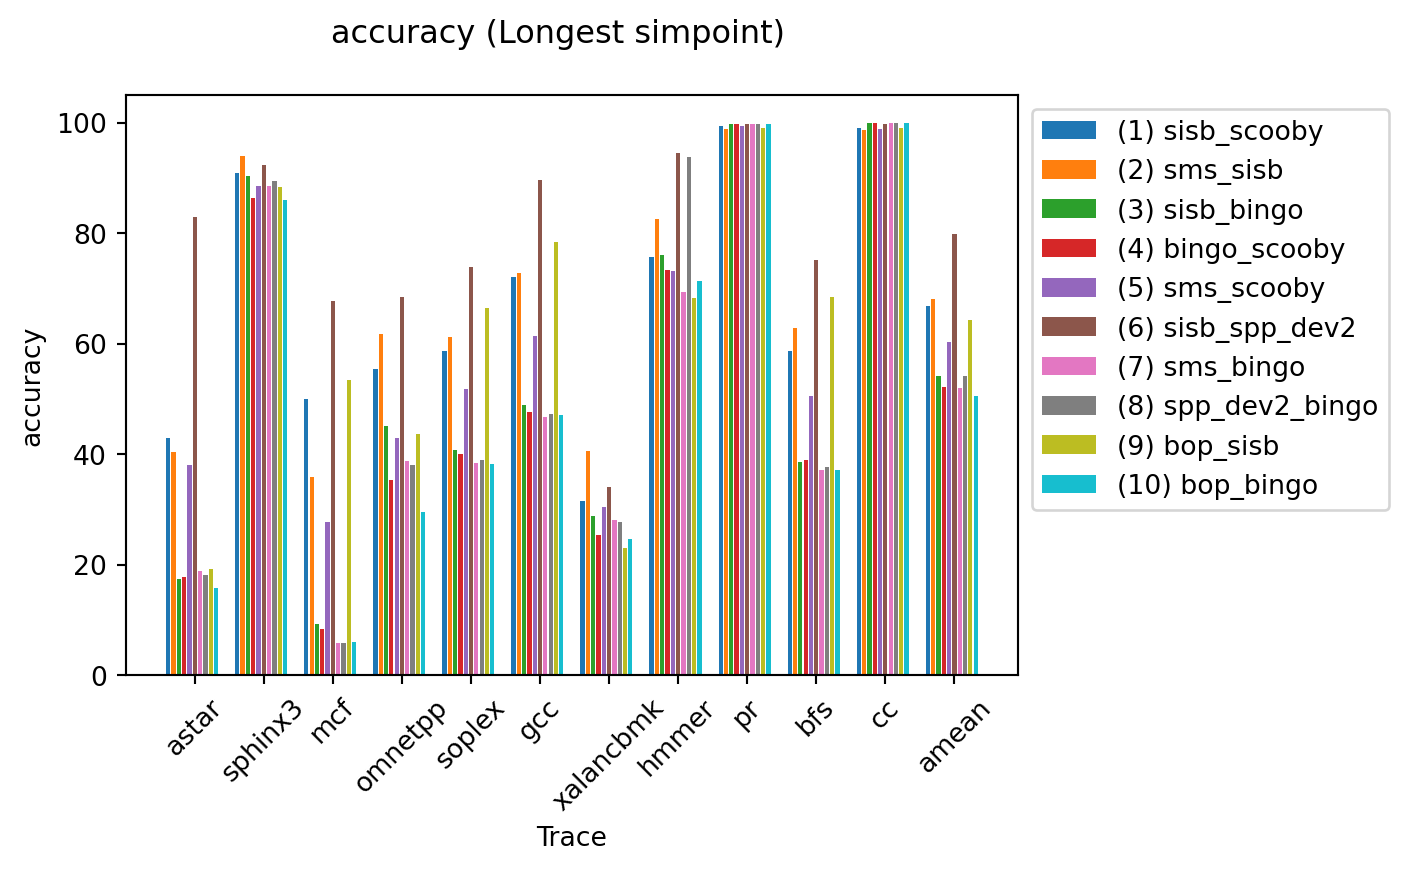

In [68]:
plot_cumulative_statistics(df, weights, metric='accuracy')#, filter_by=None)

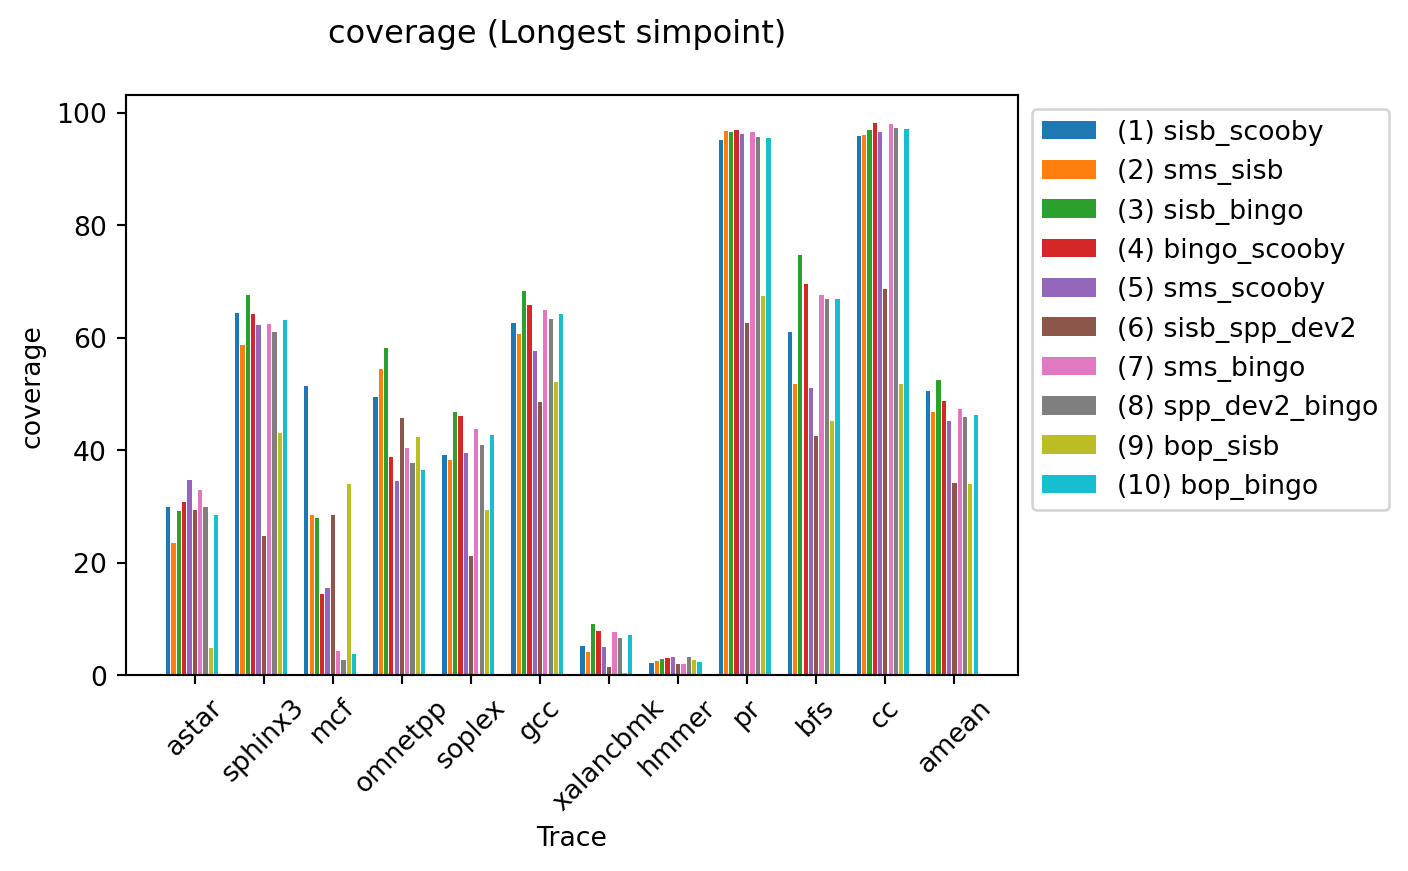

In [70]:
plot_cumulative_statistics(df, weights, metric='coverage')

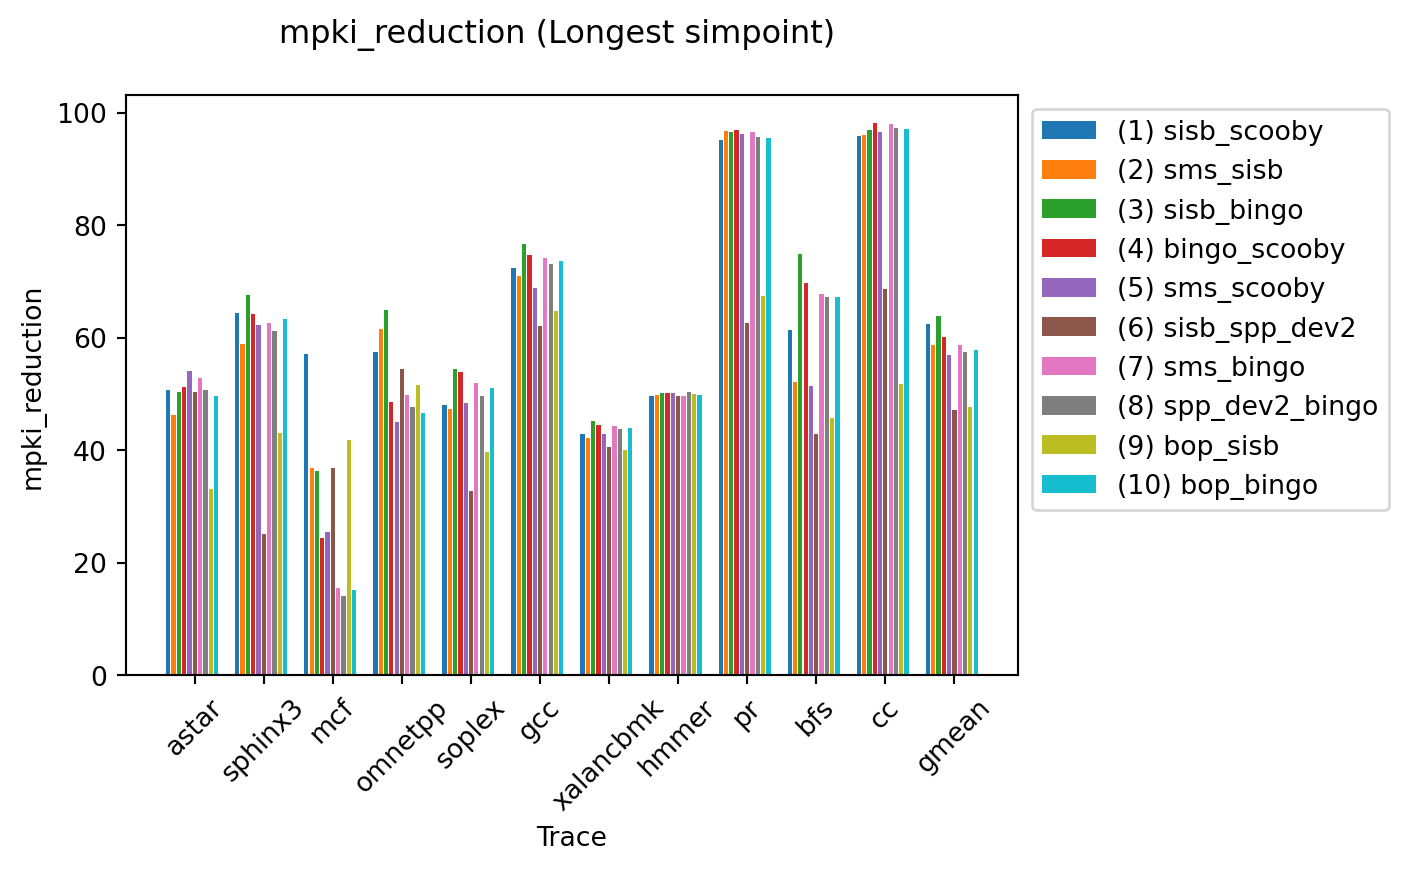

In [72]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction')

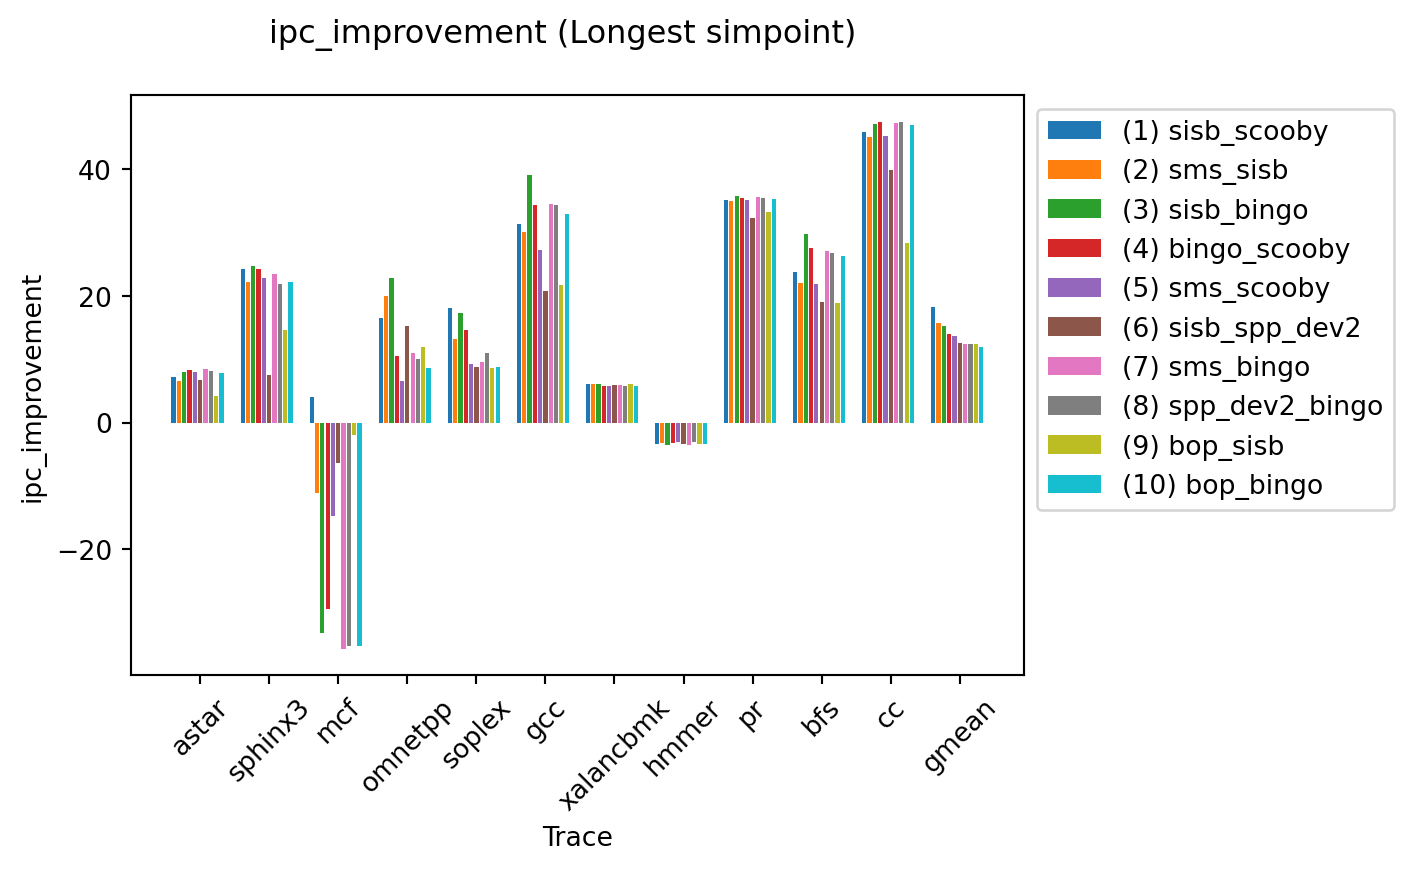

In [77]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement')

# Phase behvaior

In [235]:
def plot_phase_behavior(df, trace, metric, weights=None,
                        filter_by='ipc_improvement', filter_count=4):
    
    if filter_by is not None:
        # Get best-performing prefetcher, by <filter-by>, on longest simpoints (same as above plots)
        longest_simpoints = get_longest_simpoints(weights)
        df_ = df[df.full_trace.isin(longest_simpoints)]
        best_prefetchers = get_best_prefetchers(df_, filter_by, filter_count)
    
    df = df[df.trace == trace][['simpoint', 'prefetcher', metric]]
    pf_list = best_prefetchers if filter_by is not None else df.prefetcher.unique()
    sp_list = df.simpoint.unique()
    if len(sp_list) <= 1: # Don't plot phase behavior on single-simpoint benchmarks (e.g. GAP)
        return
    
    fig, ax = plt.subplots(dpi=120)
    
    for pf in pf_list:
        X, y = [], []
        for i, sp in enumerate(sp_list):
            X.append(i)
            y.append(df[(df.prefetcher == pf) & (df.simpoint == sp)][metric].item())
            
        if filter_by is not None:
            label = f'({best_prefetchers.index(pf)+1}) {pf}'
        else:
            label = pf
        
        ax.plot(X, y, '.-', label=label)

    # Get tick labels
    if not weights.empty:
        sp_labels = []
        for sp in sp_list:
            weight = weights[weights.trace == f'{trace}_{sp}'].weight.item()
            sp_labels.append(f'{sp} ({weight*100:.1f})%')
    else:
        sp_labels = sp_list
    
    fig.suptitle(f'{trace}: {metric} phase behavior')
    ax.set_xticks(range(0, len(sp_list)))
    ax.set_xticklabels(sp_labels)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

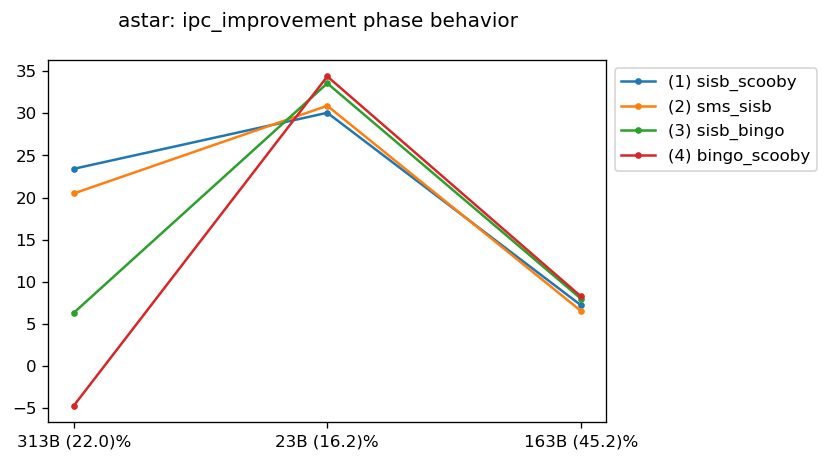

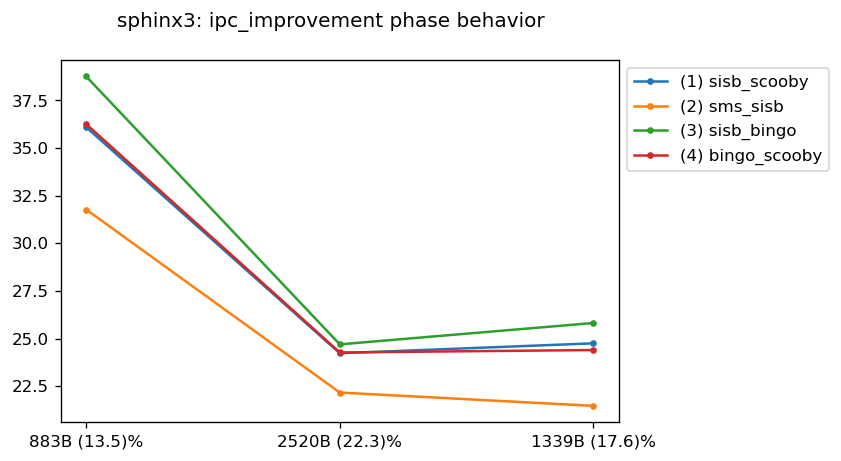

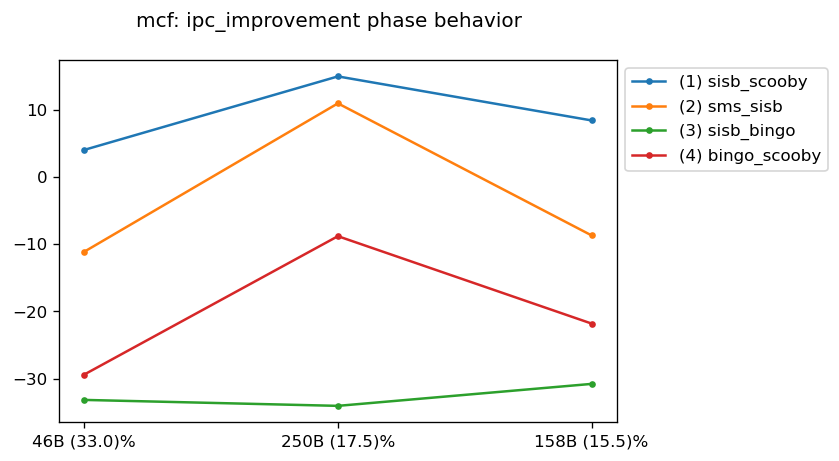

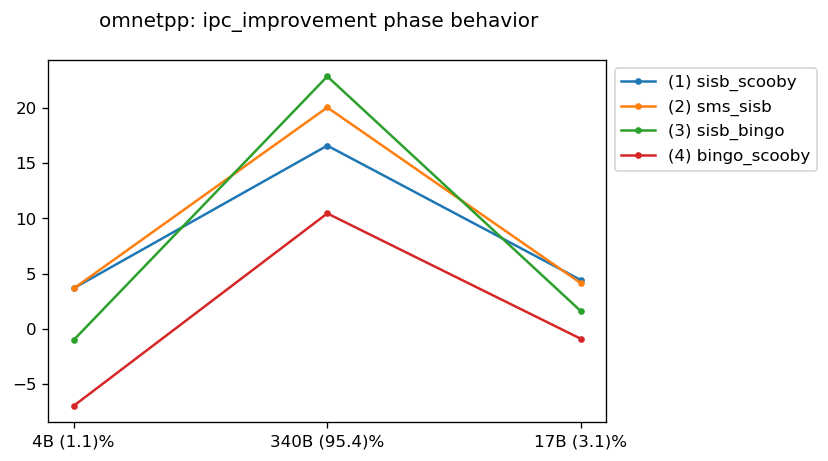

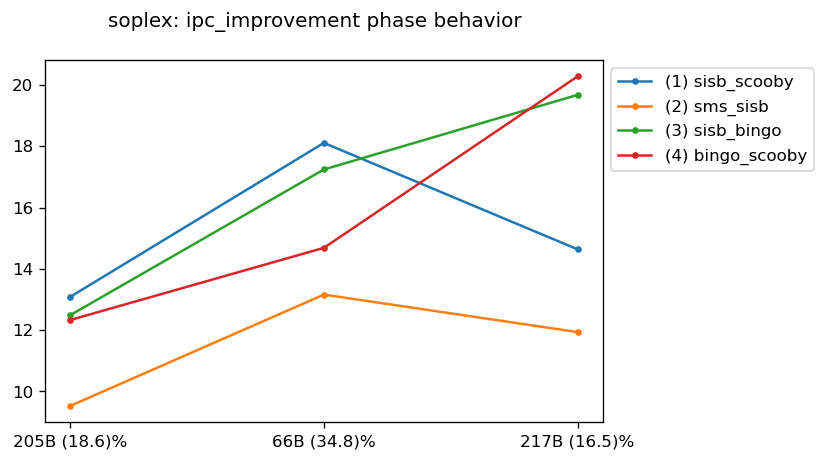

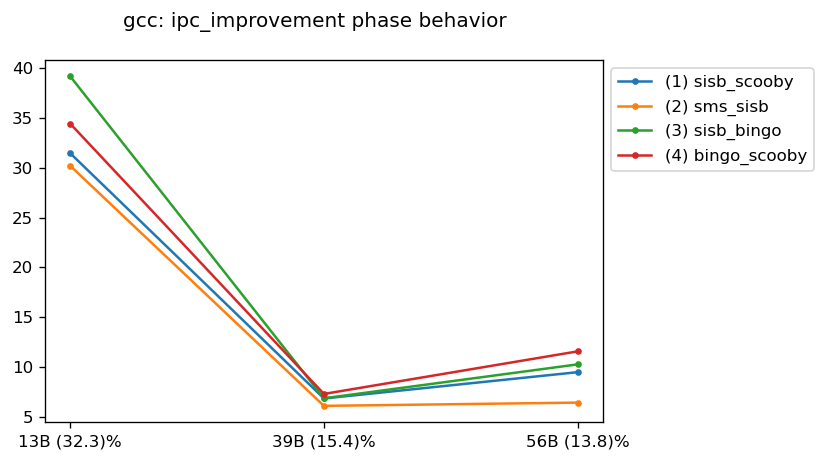

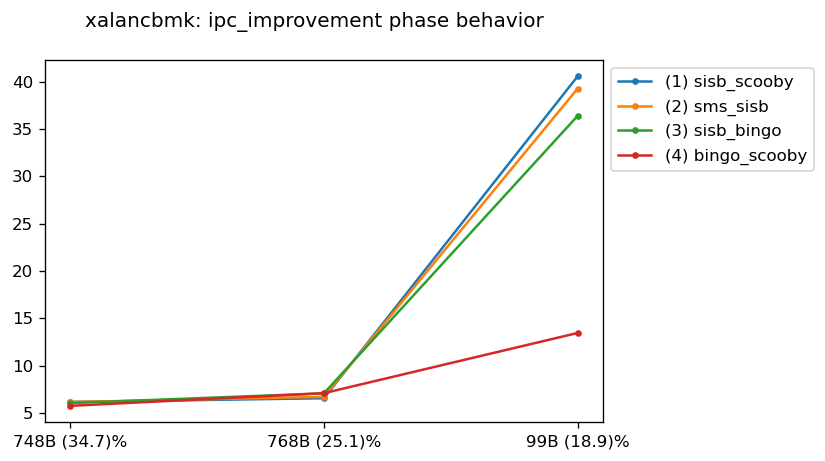

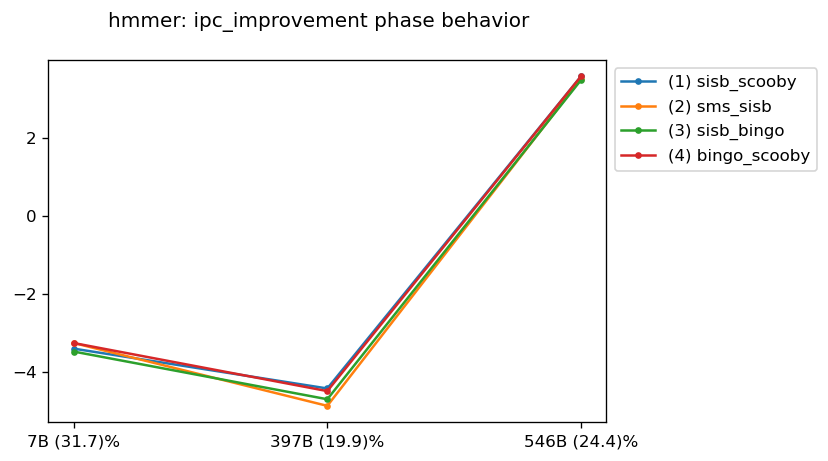

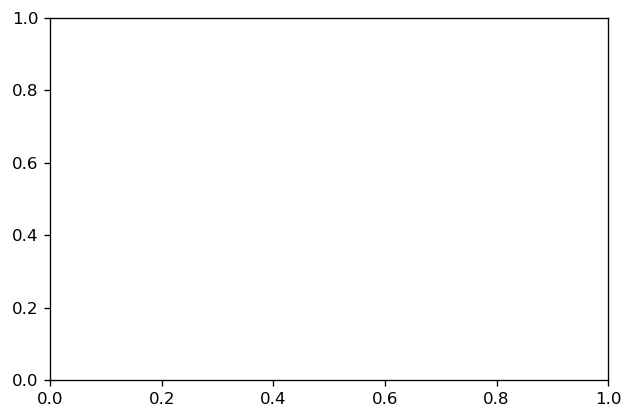

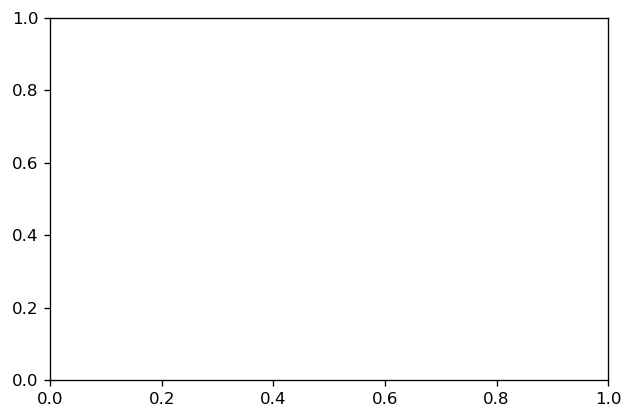

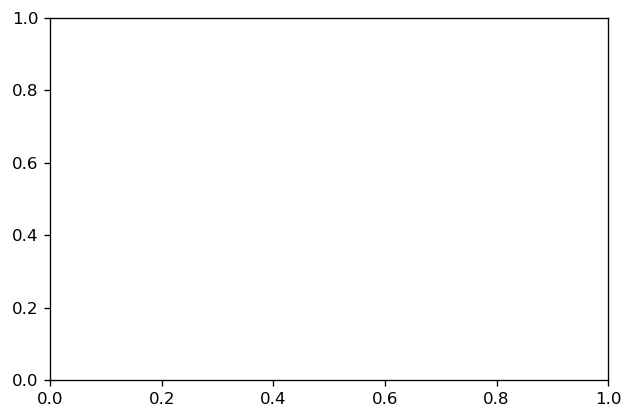

In [237]:
for tr in df.trace.unique():
    plot_phase_behavior(df, tr, 'ipc_improvement', weights=weights)

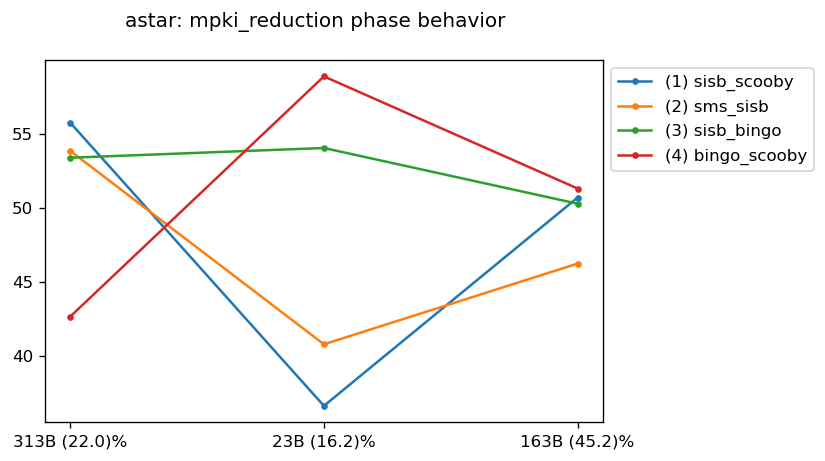

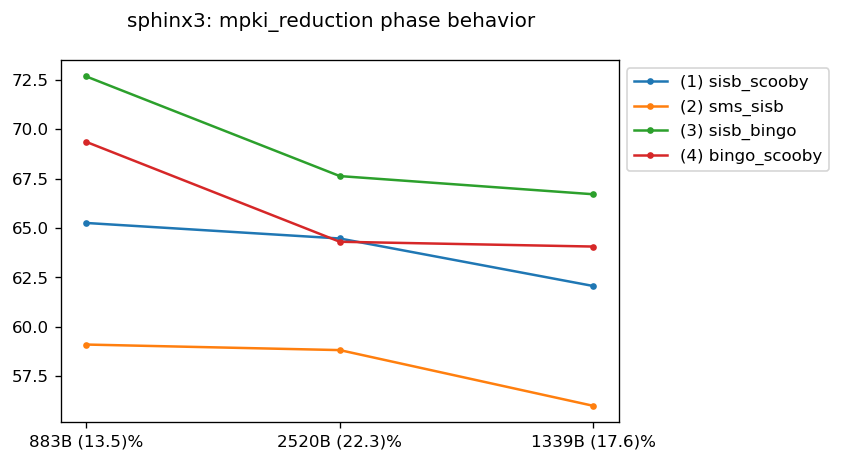

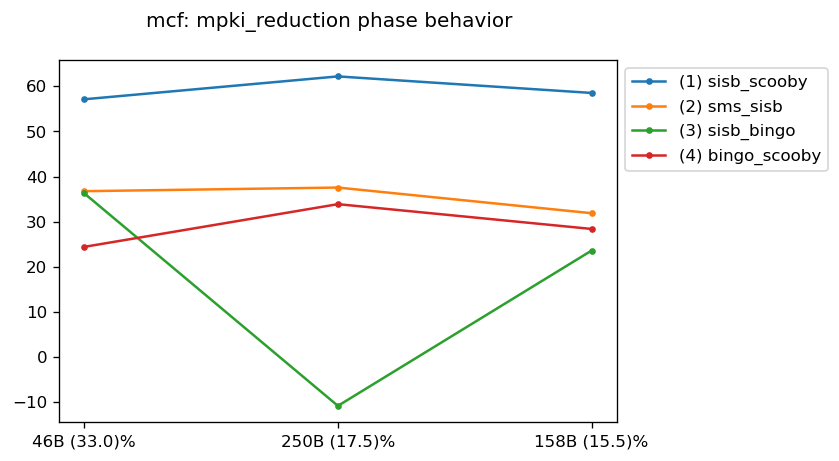

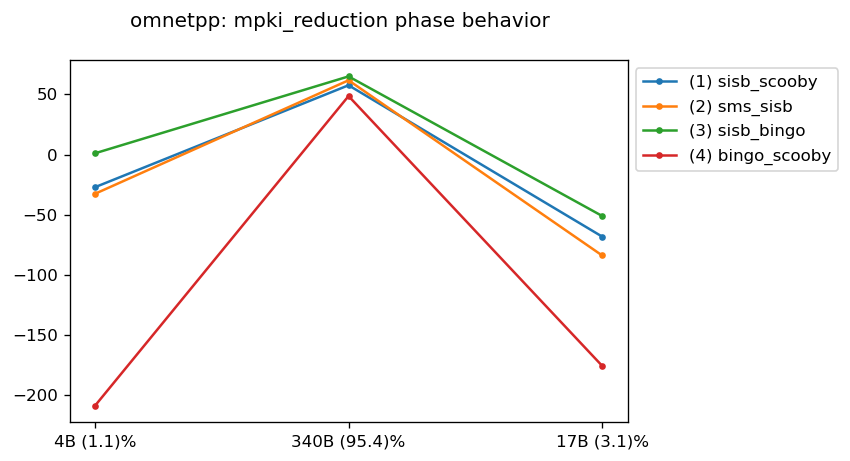

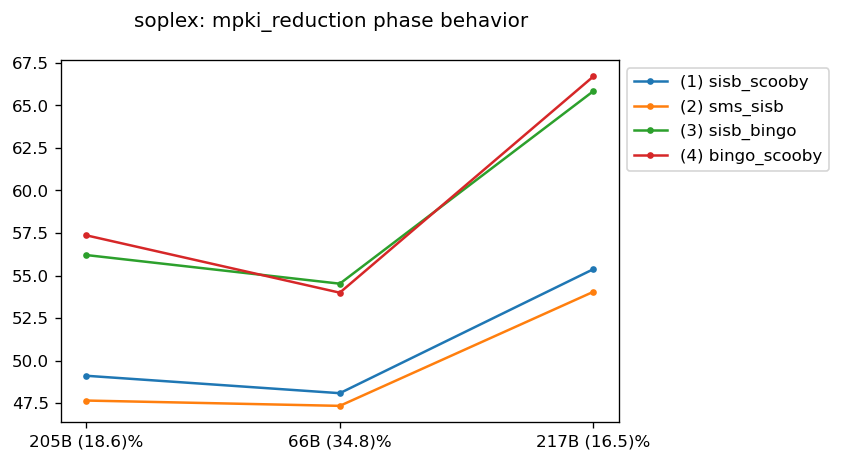

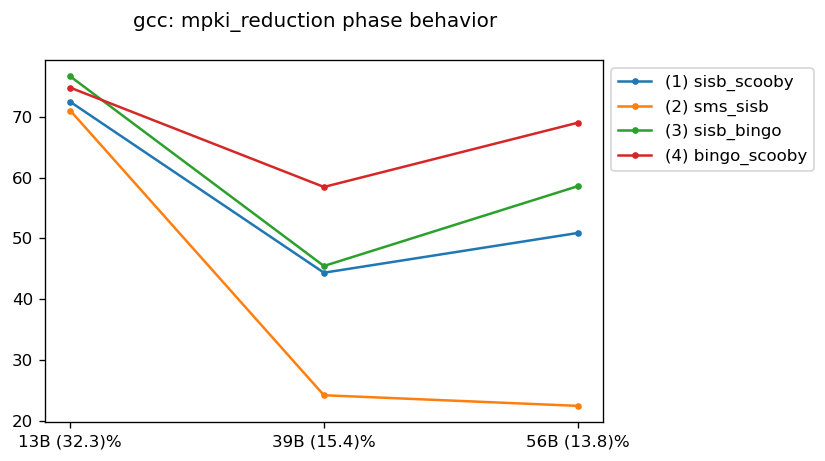

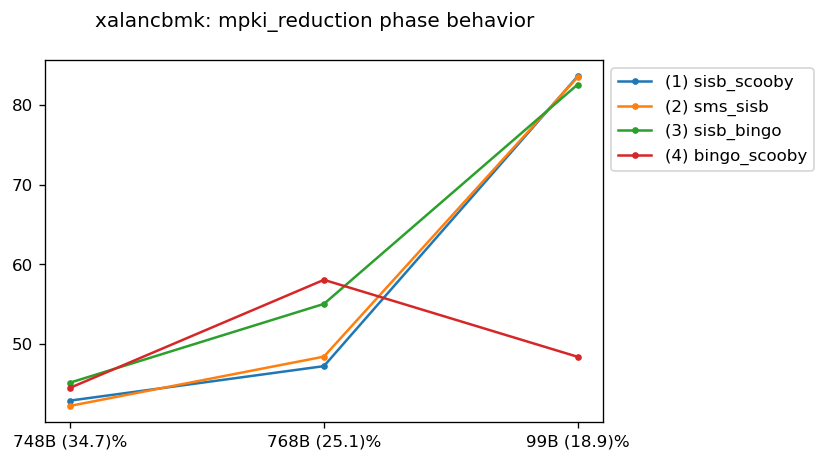

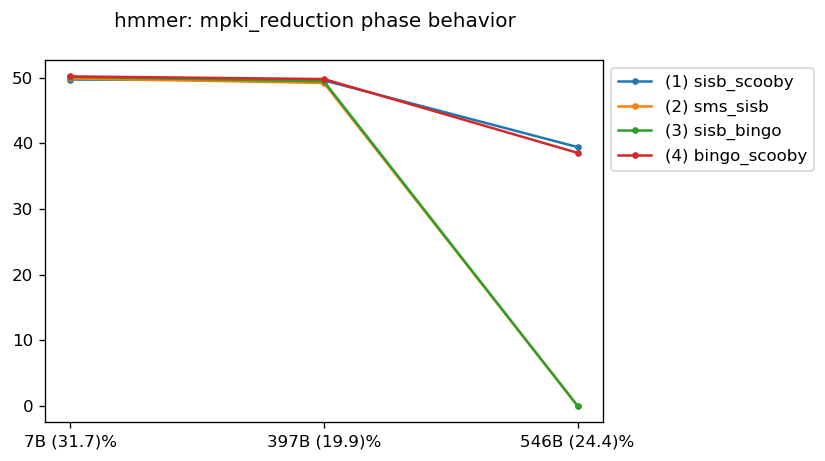

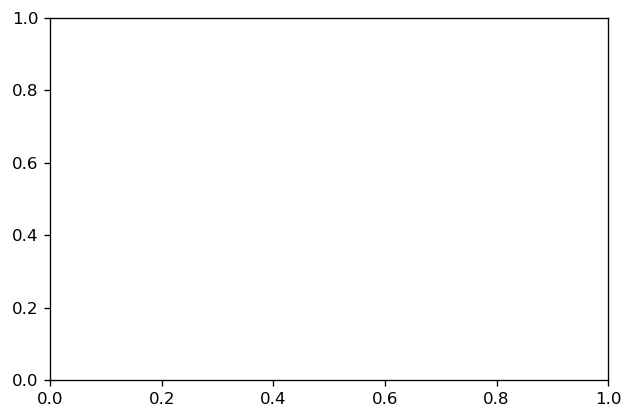

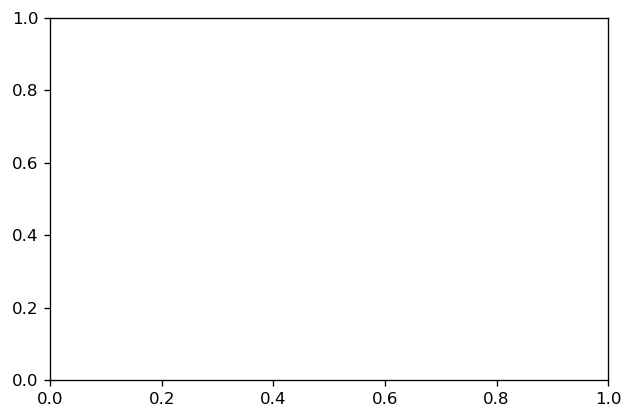

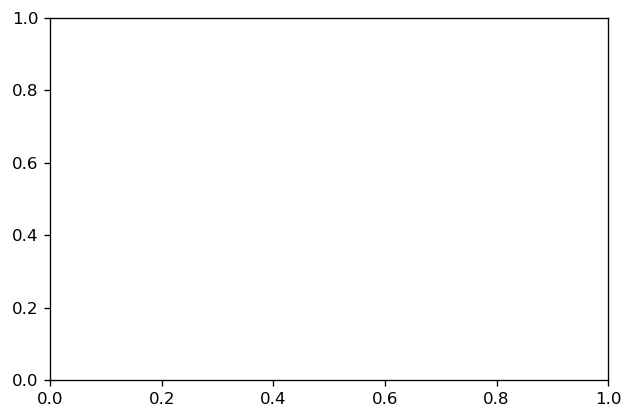

In [239]:
for tr in df.trace.unique():
    plot_phase_behavior(df, tr, 'mpki_reduction', weights=weights)